In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mpld3

In [26]:
filename = "data/CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv"
df = pd.read_csv(filename)

In [27]:
# check for missing data, if any
if df.isna().values.sum():
    df.dropna(inplace=True)

In [28]:
# change date to datetime format
df['datetime'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

In [29]:
# extract season, day of week, month, year
seasons = ['Winter','Winter','Spring','Spring','Spring','Summer',
           'Summer','Summer','Fall','Fall','Fall','Winter']
months = range(1,13)
mtos = dict(zip(months,seasons))
df['season'] = df['datetime'].dt.month.map(mtos)
df['weekday']=df['datetime'].dt.dayofweek.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 
                                               3:'Thursday',
                                              4:'Friday', 5:'Saturday', 6:'Sunday'})
df['month']=pd.DatetimeIndex(df['datetime']).month
df['year']=pd.DatetimeIndex(df['datetime']).year

In [30]:
daytypes = df.daytype.unique().tolist()
daytypedict = dict(zip(daytypes, ['Sun/Hol', 'Weekday', 'Sat']))
df['daytype']=df['daytype'].map(daytypedict)

In [31]:
stations = df.stationname.unique().tolist()
mparklist = ['Washington/Wabash', 'Clark/Lake']

In [32]:
# check out when stations with least # days open
count_days = df.groupby('stationname')['rides'].count().reset_index()
day_count_stats = count_days.describe().loc['25%','rides']
count_days[count_days['rides'] < day_count_stats].sort_values(
    by='rides').reset_index(drop=True).loc[0:9]

,stationname,rides
0,Homan,31
1,Washington/Wabash,334
2,Cermak-McCormick Place,1277
3,Morgan-Lake,2252
4,Dempster-Skokie,2282
5,Oakton-Skokie,2282
6,Washington/State,2953
7,Skokie,4111
8,Madison/Wabash,6216
9,Conservatory,6239


In [33]:
# find trends in ridership (from 2012 to 2017 years)
years_list = np.arange(2017, 2011, -5)
df_diff = df[df['year'].isin(years_list)]
df_diff = df_diff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_diff = df_diff.groupby('stationname').filter(lambda x: len(x) >1)

# find change in ridership in past 5 years
df_diff['5yr_diff'] = df_diff['rides'].diff()
df_diff['5yr_percent_diff'] = df_diff['rides'].pct_change()
df_diff = df_diff[df_diff['year']!= 2012]

In [34]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs = df_diff.sort_values(by=['5yr_diff'], ascending=False
                              ).reset_index(drop=True).loc[0:10,:]
topprops = df_diff.sort_values(by=['5yr_percent_diff'], ascending=False
                              ).reset_index(drop=True).loc[0:10,:]
top = topdiffs[topdiffs['stationname'].isin(topprops['stationname'])]
topstationlist = top.stationname.unique()

Text(0, 0.5, '% Change 2012-2017')

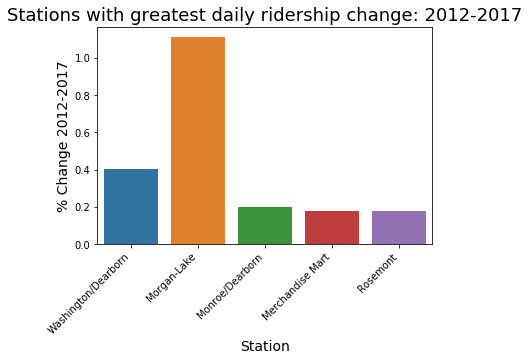

In [35]:
# Plot stations with biggest percent change in daily ridership from 2012 to 2017
fig, ax = plt.subplots()
sns.barplot(x='stationname', y='5yr_percent_diff', data=top, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Stations with greatest daily ridership change: 2012-2017', fontsize=18)
ax.set_xlabel('Station', fontsize=14)
ax.set_ylabel('% Change 2012-2017', fontsize=14)

In [36]:
# get average daily ridership yearly change for the past 5 years
df_yrdiff=pd.DataFrame()
years_list_5 = np.arange(2017, 2011, -1)
df_yrdiff = df[df['year'].isin(years_list_5)]
df_yrdiff = df_yrdiff.groupby(['stationname','year'])['rides'].mean().reset_index()

# get rid of stations w/ missing data in 2012 or 2017
df_yrdiff = df_yrdiff.groupby('stationname').filter(lambda x: len(x) >5)

# # find change in ridership in past 5 years
df_yrdiff['5yr_diff_ave'] = df_yrdiff['rides'].diff()
df_yrdiff['5yr_percent_diff_ave'] = df_yrdiff['rides'].pct_change()
df_yrdiff = df_yrdiff[df_yrdiff['year']!= 2012]
df_yrdiff=df_yrdiff.groupby('stationname').mean().reset_index()
df_yrdiff['years']=str(years_list_5[0])+'-'+str(years_list_5[-1])

In [37]:
# get 25 stations with biggest ridership change from 5 years ago
topdiffs_ave = df_yrdiff.sort_values(by=['5yr_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
topprops_ave = df_yrdiff.sort_values(by=['5yr_percent_diff_ave'], ascending=False).reset_index(drop=True).loc[0:24,:]
top_ave = topdiffs_ave[topdiffs_ave['stationname'].isin(topprops['stationname'])]
topstationlist_ave = top_ave.stationname.unique()

In [38]:
df['is_topstation_ave']=df['stationname'].isin(topstationlist_ave)

Text(0, 0.5, 'Average % Change 2012-2017')

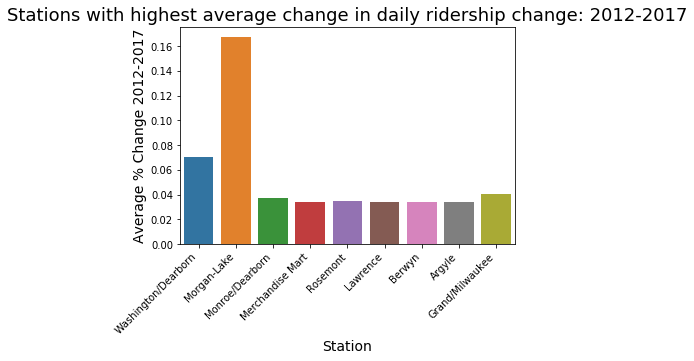

In [39]:
# Plot stations with biggest yearly average percent change 
# in daily ridership from 2012 to 2017
fig, ax = plt.subplots()
sns.barplot(x='stationname', y='5yr_percent_diff_ave', data=top_ave, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Stations with highest average change in daily ridership change: 2012-2017', 
          fontsize=18)
ax.set_xlabel('Station', fontsize=14)
ax.set_ylabel('Average % Change 2012-2017', fontsize=14)

In [ ]:
# plot ridership over time
def make_time_plot(df, station):    
    d = df[df['stationname']==station]
    x = 'datetime'
    y = 'rides'
    a=d[x]
    b=d[y]
    fig, ax = plt.subplots()
    ax.plot(a, b)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title(station)

In [ ]:
# plots stations with big changes from 2012 to 2017
for stat in topstationlist:
    make_time_plot(df, stat)

In [ ]:
# plots stations with greatest average yearly increases between 2012 and 2017
for stat in topstationlist_ave:
    make_time_plot(df, stat)

In [42]:
y=pd.DataFrame(df.groupby(by=['stationname'])['rides'].mean())
y.loc[y.idxmax()]

,rides
stationname,
Clark/Lake,13900.595838


In [44]:
df_map = pd.read_csv('data/CTA_-_System_Information_-_List_of__L__Stops.csv')
loc_string = df_map[df_map['STATION_NAME']=='Morse'].reset_index().loc[0,'Location']
lat,long = loc_string.strip('()').split(',')

In [45]:
lats = []
lons = []
for val in df_map.Location:
    lat, long = val.strip('()').split(',')
    lats.append(float(lat))
    lons.append(float(long))
df_map['latitude']=lats  
df_map['longitude']=lons  

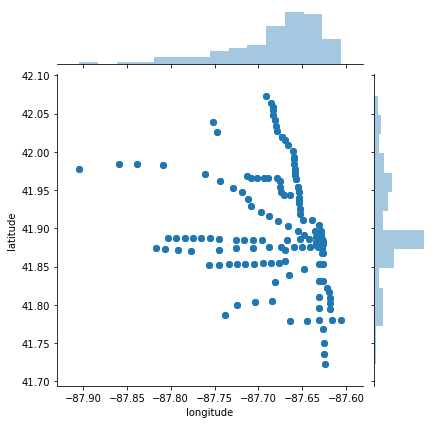

In [48]:
sns.jointplot(x="longitude",y="latitude", data=df_map)

In [50]:
top_rides = top.set_index('stationname')
top_map = top_map.set_index('STATION_NAME')
top_ave_rides = top_ave.set_index('stationname')

In [51]:
all_top = top_map.join(top_ave_rides, how='outer')

In [54]:
all_top

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,...,Pnk,O,Location,latitude,longitude,year,rides,5yr_diff_ave,5yr_percent_diff_ave,years
Argyle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,2850.303605,79.838823,0.033913,2017-2012
Berwyn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,3095.403080,85.259370,0.033793,2017-2012
Grand/Milwaukee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,2286.360831,78.981678,0.040325,2017-2012
Lawrence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,3103.773687,94.559178,0.033956,2017-2012
Merchandise Mart,30091.0,S,Merchandise Mart (Loop-bound),Merchandise Mart (Brown & Purple Lines),40460.0,True,False,False,False,True,...,False,False,"(41.888969, -87.633924)",41.888969,-87.633924,2015,5798.262773,184.928264,0.033634,2017-2012
Merchandise Mart,30090.0,N,Merchandise Mart (Kimball-Linden-bound),Merchandise Mart (Brown & Purple Lines),40460.0,True,False,False,False,True,...,False,False,"(41.888969, -87.633924)",41.888969,-87.633924,2015,5798.262773,184.928264,0.033634,2017-2012
Monroe/Dearborn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,6099.555407,215.521177,0.037385,2017-2012
Morgan-Lake,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,2130.508278,262.139402,0.167304,2017-2012
Rosemont,30159.0,N,Rosemont (O'Hare-bound),Rosemont (Blue Line),40820.0,True,False,True,False,False,...,False,False,"(41.983507, -87.859388)",41.983507,-87.859388,2015,5577.992987,168.018322,0.034720,2017-2012
Rosemont,30160.0,S,Rosemont (Forest Pk-bound),Rosemont (Blue Line),40820.0,True,False,True,False,False,...,False,False,"(41.983507, -87.859388)",41.983507,-87.859388,2015,5577.992987,168.018322,0.034720,2017-2012


In [53]:
import mpld3

fig, ax = plt.subplots(subplot_kw=dict(facecolor='#EEEEEE'))

scatter = ax.scatter(np.array(all_top.longitude, dtype=float),
                     np.array(all_top.latitude, dtype=float),
                     c=np.random.random(size=len(all_top.latitude)),
                     s=np.array(5000 * all_top['5yr_percent_diff_ave'] , dtype=float),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')
ax.set_xlim([-87.9,-87.6])
ax.set_ylim([41.7,42.1])
ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = all_top.index.tolist()
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()